# Targets: Using Machine Learning Classification Models to Identify Salient Predictors of Cannabis Arrests in New York City, 2006-2018

# Machine Learning Notebook for Classification Models Part III

This notebook continues the work done in Part I and II, this time focusing on building classification models that help differentiate the five types of cannabis crime in New York City between 2006-2018: misdemeanor possession, violation possession, felony possession, misdemeanor sales, and felony sales. These models will sequentially classify each crime type from the other four crime types using binary classification. This notebook continues to explore the line between cannabis possession and sales crimes at a greater level of granularity, while aiming to discover the most salient coefficients of the classification models to uncover the features of the dataset with the strongest relationship to each of the five cannabis crime types.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pickle
from sklearn.utils import resample

In [2]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 1296)

The DataFrame of all 220,304 cannabis crimes is loaded into the 'df' DataFrame, and its shape is called for reference.

In [3]:
df = pd.read_csv('nyc_cann_for_ml.csv', index_col=0)

In [4]:
df.shape

(220304, 1302)

# Misdemeanor Possession Crimes

The misdemeanor possession cases have a value of '1' in the 'misd_poss' feature, and all other cannabis crimes have a value of '0'. Because this round of classification is focused on misdemeanor possession cannabis crimes versus all other cannabis crimes, a set of features that also describe the type of crime must be dropped from the DataFrame in order to avoid leakage. These features are dropped in the next cell, which also creates a subsetted DataFrame for use in classifying misdemeanor possession crimes. 'CMPLNT_NUM' uniquely identifies each crime, so it is also dropped to avoid leakage (as described in the data cleaning notebooks for the creation of the cannabis/non-cannabis DataFrame).

In [5]:
df_mp = df.drop(columns = ['CMPLNT_NUM', 'possession', 'viol_poss', 'felony_poss', 'misd_sales', 'felony_sales'])

In [6]:
df_mp['misd_poss'].value_counts()

1    197224
0     23080
Name: misd_poss, dtype: int64

The .head() method is called on the 'df_mp' DataFrame for reference.

In [8]:
df_mp.head()

,Latitude,Longitude,misd_poss,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve,mlk,pres,easter,diwali,pr_parade,yomkippur,rosh_hashanah,eid_al_fitr,eid_al_adha,hanukkah,memorial_day,labor_day,thanksgiving,closest_subway_distance_l1,closest_subway_distance_l2,wtc_l1,nyse_l1,bk_bridge_l1,city_hall_l1,manh_bridge_l1,will_bridge_l1,wash_sq_park_l1,union_sq_l1,penn_station_l1,times_sq_l1,rock_center_l1,empire_st_bldg_l1,lincoln_ctr_l1,central_pk_l1,apollo_th_l1,yankee_stad_l1,mets_stad_l1,queens_l1,prospect_pk_l1,downtown_bk_l1,si_ferry_l1,port_authority_l1,nypd_hq_l1,mdc_l1,rikers_l1,nysc_l1,wtc_l2,nyse_l2,bk_bridge_l2,city_hall_l2,manh_bridge_l2,will_bridge_l2,wash_sq_park_l2,union_sq_l2,penn_station_l2,times_sq_l2,rock_center_l2,empire_st_bldg_l2,lincoln_ctr_l2,central_pk_l2,apollo_th_l2,yankee_stad_l2,mets_stad_l2,queens_l2,prospect_pk_l2,downtown_bk_l2,si_ferry_l2,port_authority_l2,nypd_hq_l2,mdc_l2,rikers_l2,nysc_l2,ADDR_PCT_CD_1.0,ADDR_PCT_CD_5.0,ADDR_PCT_CD_6.0,ADDR_PCT_CD_7.0,ADDR_PCT_CD_9.0,ADDR_PCT_CD_10.0,ADDR_PCT_CD_13.0,ADDR_PCT_CD_14.0,ADDR_PCT_CD_17.0,ADDR_PCT_CD_18.0,ADDR_PCT_CD_19.0,ADDR_PCT_CD_20.0,ADDR_PCT_CD_22.0,ADDR_PCT_CD_23.0,ADDR_PCT_CD_24.0,ADDR_PCT_CD_25.0,ADDR_PCT_CD_26.0,ADDR_PCT_CD_28.0,ADDR_PCT_CD_30.0,ADDR_PCT_CD_32.0,ADDR_PCT_CD_33.0,ADDR_PCT_CD_34.0,ADDR_PCT_CD_40.0,ADDR_PCT_CD_41.0,ADDR_PCT_CD_42.0,ADDR_PCT_CD_43.0,ADDR_PCT_CD_44.0,ADDR_PCT_CD_45.0,ADDR_PCT_CD_46.0,ADDR_PCT_CD_47.0,ADDR_PCT_CD_48.0,ADDR_PCT_CD_49.0,ADDR_PCT_CD_50.0,ADDR_PCT_CD_52.0,ADDR_PCT_CD_60.0,ADDR_PCT_CD_61.0,ADDR_PCT_CD_62.0,ADDR_PCT_CD_63.0,ADDR_PCT_CD_66.0,ADDR_PCT_CD_67.0,ADDR_PCT_CD_68.0,ADDR_PCT_CD_69.0,ADDR_PCT_CD_70.0,ADDR_PCT_CD_71.0,ADDR_PCT_CD_72.0,ADDR_PCT_CD_73.0,ADDR_PCT_CD_75.0,ADDR_PCT_CD_76.0,ADDR_PCT_CD_77.0,ADDR_PCT_CD_78.0,ADDR_PCT_CD_79.0,ADDR_PCT_CD_81.0,ADDR_PCT_CD_83.0,ADDR_PCT_CD_84.0,ADDR_PCT_CD_88.0,ADDR_PCT_CD_90.0,ADDR_PCT_CD_94.0,ADDR_PCT_CD_100.0,ADDR_PCT_CD_101.0,ADDR_PCT_CD_102.0,ADDR_PCT_CD_103.0,ADDR_PCT_CD_104.0,ADDR_PCT_CD_105.0,ADDR_PCT_CD_106.0,ADDR_PCT_CD_107.0,ADDR_PCT_CD_108.0,ADDR_PCT_CD_109.0,ADDR_PCT_CD_110.0,ADDR_PCT_CD_111.0,ADDR_PCT_CD_112.0,ADDR_PCT_CD_113.0,ADDR_PCT_CD_114.0,ADDR_PCT_CD_115.0,ADDR_PCT_CD_120.0,ADDR_PCT_CD_121.0,ADDR_PCT_CD_122.0,ADDR_PCT_CD_123.0,BORO_NM_BRONX,BORO_NM_BROOKLYN,BORO_NM_MANHATTAN,BORO_NM_QUEENS,BORO_NM_STATEN ISLAND,BORO_NM_unknown,LOC_OF_OCCUR_DESC_FRONT OF,LOC_OF_OCCUR_DESC_INSIDE,LOC_OF_OCCUR_DESC_OPPOSITE OF,LOC_OF_OCCUR_DESC_REAR OF,LOC_OF_OCCUR_DESC_unknown,PREM_TYP_DESC_ABANDONED BUILDING,PREM_TYP_DESC_AIRPORT TERMINAL,PREM_TYP_DESC_ATM,PREM_TYP_DESC_BANK,PREM_TYP_DESC_BAR/NIGHT CLUB,PREM_TYP_DESC_BEAUTY & NAIL SALON,PREM_TYP_DESC_BOOK/CARD,PREM_TYP_DESC_BRIDGE,PREM_TYP_DESC_BUS (NYC TRANSIT),PREM_TYP_DESC_BUS (OTHER),PREM_TYP_DESC_BUS STOP,PREM_TYP_DESC_BUS TERMINAL,PREM_TYP_DESC_CANDY STORE,PREM_TYP_DESC_CEMETERY,PREM_TYP_DESC_CHAIN STORE,PREM_TYP_DESC_CHECK CASHING BUSINESS,PREM_TYP_DESC_CHURCH,PREM_TYP_DESC_CLOTHING/BOUTIQUE,PREM_TYP_DESC_COMMERCIAL BUILDING,PREM_TYP_DESC_CONSTRUCTION SITE,PREM_TYP_DESC_DEPARTMENT STORE,PREM_TYP_DESC_DOCTOR/DENTIST OFFICE,PREM_TYP_DESC_DRUG STORE,PREM_TYP_DESC_DRY CLEANER/LAUNDRY,PREM_TYP_DESC_FACTORY/WAREHOUSE,PREM_TYP_DESC_FAST FOOD,PREM_TYP_DESC_FERRY/FERRY TERMINAL,PREM_TYP_DESC_FOOD SUPERMARKET,PREM_TYP_DESC_GAS STATION,PREM_TYP_DESC_GROCERY/BODEGA,PREM_TYP_DESC_GYM/FITNESS FACILITY,PREM_TYP_DESC_HIGHWAY/PARKWAY,PREM_TYP_DESC_HOSPITAL,PREM_TYP_DESC_HOTEL/MOTEL,PREM_TYP_DESC_JEWELRY,PREM_TYP_DESC_LIQUOR STORE,PREM_TYP_DESC_MARINA/PIER,PREM_TYP_DESC_OPEN AREAS (OPEN LOTS),PREM_TYP_DESC_OTHER,PREM_TYP_DESC_OTHER HOUSE OF WORSHIP,PREM_TYP_DESC_PARK/PLAYGROUND,PREM_TYP_DESC_PARKING LOT/GARAGE (PRIVATE),PREM_TYP_DESC_PARKING LOT/GARAGE (PUBLIC),PR

## Logistic Regression Classifying Misdemeanor Possession Cannabis Crimes from all other Cannabis Crimes

In part I of the machine learning notebooks, the top two best performing logistic regression algorithms used scaled data, the 'lbfgs' solver, and had C values of 0.1 and 1.0. The top 3rd through 8th best performing logistic regression algorithms used scaled data, the 'saga' solver, and a mixture of penalties and C values. The top 14 best performing logistic algorithms used scaled data, so only scaled data was used in that notebook. 

As the DataFrame used in this notebook is the same as the DataFrame used in part II, the best performing logistic regression algorithms in part II are likely to be similarly effective with the five levels of cannabis crime. For this reason, and for the sake of efficiency, the top five best performing algorithms used in part II will be used here in part III. Scaled data will again be used in Part III and RandomForest algorithms will be investigated. 

Because the classes for each of the five crime levels are very imbalanced, minority class oversampling will be used to create balanced classification models, as was described in part II. The source for these resampling techniques was discovered in this article by Dr. Brownlee: https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18 

## Logistic Regression Using the Top Performing Algorithms on Scaled Data

For this round of classifications, the top five best performing Logistic Regression algorithms used in part II are used here on scaled data. In order to find the best model that can generalize to unseen data, the DataFrame is split into training and test sets, and hyperparameters are tuned to find the best model with the highest accuracy score, precision, recall, and F1 score on the test set, after the resampling of the minority class protocol is carried out. 

In order to tune the hyperparameters, the LogisticRegression classifier is assigned several times with different combinations of hyperparameter values. For each assignment of the classifier, 

a) the classifier is fitted to the training data, 

b) the target feature's values are predicted from the test feature set, 

c) the accuracy score is computed from the test set, 

d) the 'confusion_matrix' and 'classification_report' is called from the test target feature values and predicted test target values to return the precision, recall, and F1 scores, and

e) accuracy, precision, recall, and F1 scores will then be entered into a Hyperparameter Tuning Table in Excel, which will be read into the data space after hyperparameter tuning is resolved. 

After the best combination of hyperparameters are discovered from using the top five best performing algorithms from part II on scaled data, ROC and Precision-Recall curves (and their AUCs) will be calculated and displayed to present a visual image of the evaluation of the best LogisticRegression model.

## Scaling the DataFrame

We now use MinMaxScaler to normalize the data.

In [7]:
scaler = MinMaxScaler()

In [8]:
scaler.fit(df_mp)

/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


MinMaxScaler(copy=True, feature_range=(0, 1))

In [9]:
df_mp_scaled = pd.DataFrame(scaler.transform(df_mp), columns=df_mp.columns, index=df_mp.index)

In [10]:
df_mp_scaled.head()

,Latitude,Longitude,misd_poss,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve,mlk,pres,easter,diwali,pr_parade,yomkippur,rosh_hashanah,eid_al_fitr,eid_al_adha,hanukkah,memorial_day,labor_day,thanksgiving,closest_subway_distance_l1,closest_subway_distance_l2,wtc_l1,nyse_l1,bk_bridge_l1,city_hall_l1,manh_bridge_l1,will_bridge_l1,wash_sq_park_l1,union_sq_l1,penn_station_l1,times_sq_l1,rock_center_l1,empire_st_bldg_l1,lincoln_ctr_l1,central_pk_l1,apollo_th_l1,yankee_stad_l1,mets_stad_l1,queens_l1,prospect_pk_l1,downtown_bk_l1,si_ferry_l1,port_authority_l1,nypd_hq_l1,mdc_l1,rikers_l1,nysc_l1,wtc_l2,nyse_l2,bk_bridge_l2,city_hall_l2,manh_bridge_l2,will_bridge_l2,wash_sq_park_l2,union_sq_l2,penn_station_l2,times_sq_l2,rock_center_l2,empire_st_bldg_l2,lincoln_ctr_l2,central_pk_l2,apollo_th_l2,yankee_stad_l2,mets_stad_l2,queens_l2,prospect_pk_l2,downtown_bk_l2,si_ferry_l2,port_authority_l2,nypd_hq_l2,mdc_l2,rikers_l2,nysc_l2,ADDR_PCT_CD_1.0,ADDR_PCT_CD_5.0,ADDR_PCT_CD_6.0,ADDR_PCT_CD_7.0,ADDR_PCT_CD_9.0,ADDR_PCT_CD_10.0,ADDR_PCT_CD_13.0,ADDR_PCT_CD_14.0,ADDR_PCT_CD_17.0,ADDR_PCT_CD_18.0,ADDR_PCT_CD_19.0,ADDR_PCT_CD_20.0,ADDR_PCT_CD_22.0,ADDR_PCT_CD_23.0,ADDR_PCT_CD_24.0,ADDR_PCT_CD_25.0,ADDR_PCT_CD_26.0,ADDR_PCT_CD_28.0,ADDR_PCT_CD_30.0,ADDR_PCT_CD_32.0,ADDR_PCT_CD_33.0,ADDR_PCT_CD_34.0,ADDR_PCT_CD_40.0,ADDR_PCT_CD_41.0,ADDR_PCT_CD_42.0,ADDR_PCT_CD_43.0,ADDR_PCT_CD_44.0,ADDR_PCT_CD_45.0,ADDR_PCT_CD_46.0,ADDR_PCT_CD_47.0,ADDR_PCT_CD_48.0,ADDR_PCT_CD_49.0,ADDR_PCT_CD_50.0,ADDR_PCT_CD_52.0,ADDR_PCT_CD_60.0,ADDR_PCT_CD_61.0,ADDR_PCT_CD_62.0,ADDR_PCT_CD_63.0,ADDR_PCT_CD_66.0,ADDR_PCT_CD_67.0,ADDR_PCT_CD_68.0,ADDR_PCT_CD_69.0,ADDR_PCT_CD_70.0,ADDR_PCT_CD_71.0,ADDR_PCT_CD_72.0,ADDR_PCT_CD_73.0,ADDR_PCT_CD_75.0,ADDR_PCT_CD_76.0,ADDR_PCT_CD_77.0,ADDR_PCT_CD_78.0,ADDR_PCT_CD_79.0,ADDR_PCT_CD_81.0,ADDR_PCT_CD_83.0,ADDR_PCT_CD_84.0,ADDR_PCT_CD_88.0,ADDR_PCT_CD_90.0,ADDR_PCT_CD_94.0,ADDR_PCT_CD_100.0,ADDR_PCT_CD_101.0,ADDR_PCT_CD_102.0,ADDR_PCT_CD_103.0,ADDR_PCT_CD_104.0,ADDR_PCT_CD_105.0,ADDR_PCT_CD_106.0,ADDR_PCT_CD_107.0,ADDR_PCT_CD_108.0,ADDR_PCT_CD_109.0,ADDR_PCT_CD_110.0,ADDR_PCT_CD_111.0,ADDR_PCT_CD_112.0,ADDR_PCT_CD_113.0,ADDR_PCT_CD_114.0,ADDR_PCT_CD_115.0,ADDR_PCT_CD_120.0,ADDR_PCT_CD_121.0,ADDR_PCT_CD_122.0,ADDR_PCT_CD_123.0,BORO_NM_BRONX,BORO_NM_BROOKLYN,BORO_NM_MANHATTAN,BORO_NM_QUEENS,BORO_NM_STATEN ISLAND,BORO_NM_unknown,LOC_OF_OCCUR_DESC_FRONT OF,LOC_OF_OCCUR_DESC_INSIDE,LOC_OF_OCCUR_DESC_OPPOSITE OF,LOC_OF_OCCUR_DESC_REAR OF,LOC_OF_OCCUR_DESC_unknown,PREM_TYP_DESC_ABANDONED BUILDING,PREM_TYP_DESC_AIRPORT TERMINAL,PREM_TYP_DESC_ATM,PREM_TYP_DESC_BANK,PREM_TYP_DESC_BAR/NIGHT CLUB,PREM_TYP_DESC_BEAUTY & NAIL SALON,PREM_TYP_DESC_BOOK/CARD,PREM_TYP_DESC_BRIDGE,PREM_TYP_DESC_BUS (NYC TRANSIT),PREM_TYP_DESC_BUS (OTHER),PREM_TYP_DESC_BUS STOP,PREM_TYP_DESC_BUS TERMINAL,PREM_TYP_DESC_CANDY STORE,PREM_TYP_DESC_CEMETERY,PREM_TYP_DESC_CHAIN STORE,PREM_TYP_DESC_CHECK CASHING BUSINESS,PREM_TYP_DESC_CHURCH,PREM_TYP_DESC_CLOTHING/BOUTIQUE,PREM_TYP_DESC_COMMERCIAL BUILDING,PREM_TYP_DESC_CONSTRUCTION SITE,PREM_TYP_DESC_DEPARTMENT STORE,PREM_TYP_DESC_DOCTOR/DENTIST OFFICE,PREM_TYP_DESC_DRUG STORE,PREM_TYP_DESC_DRY CLEANER/LAUNDRY,PREM_TYP_DESC_FACTORY/WAREHOUSE,PREM_TYP_DESC_FAST FOOD,PREM_TYP_DESC_FERRY/FERRY TERMINAL,PREM_TYP_DESC_FOOD SUPERMARKET,PREM_TYP_DESC_GAS STATION,PREM_TYP_DESC_GROCERY/BODEGA,PREM_TYP_DESC_GYM/FITNESS FACILITY,PREM_TYP_DESC_HIGHWAY/PARKWAY,PREM_TYP_DESC_HOSPITAL,PREM_TYP_DESC_HOTEL/MOTEL,PREM_TYP_DESC_JEWELRY,PREM_TYP_DESC_LIQUOR STORE,PREM_TYP_DESC_MARINA/PIER,PREM_TYP_DESC_OPEN AREAS (OPEN LOTS),PREM_TYP_DESC_OTHER,PREM_TYP_DESC_OTHER HOUSE OF WORSHIP,PREM_TYP_DESC_PARK/PLAYGROUND,PREM_TYP_DESC_PARKING LOT/GARAGE (PRIVATE),PREM_TYP_DESC_PARKING LOT/GARAGE (PUBLIC),PR

The target feature in this series of classifications is the binary feature 'misd_poss', with a value of 1 for misdemeanor cannabis crimes and 0 for all other cannabis crimes. The target feature is assigned to y.

In [10]:
y = df_mp_scaled['misd_poss']

The feature set is assigned to X, which includes all features in the 'df_mp_scaled' DataFrame which are not the target.

In [11]:
target_names = ['misd_poss']
X = df_mp_scaled[[cn for cn in df_mp_scaled.columns if cn not in target_names]]

## Training and Test Data Split

In order to find the best model that can generalize to unseen data, the DataFrame is split into training and test sets. 

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Random Forest Algorithm

It is always a good idea to investigate one other type of classifier when doing machine learning classification. Random Forest is a good choice, as it has been found to be very useful with datasets with large sample and feature sizes, where the feature size is smaller than the sample size. Also, Random Forest is good for imbalanced datasets (https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18). For these reasons, it is carried out below on the original training set as an experiment, first with 10 estimators and then 100.

In [17]:
rfc_mp_1 = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

In [18]:
rfc_mp_pred_1 = rfc_mp_1.predict(X_test)

In [19]:
accuracy_score(y_test, rfc_mp_pred_1)

0.8854996482149747

The confusion matrix shows that there are 1,017 true positives, 1,446 false positives, 3,599 false negatives, and 37,999 true negatives.

In [20]:
confusion_matrix(y_test, rfc_mp_pred_1)

array([[ 1017,  3599],
       [ 1446, 37999]])

In [21]:
print(classification_report(y_test, rfc_mp_pred_1))

              precision    recall  f1-score   support

         0.0       0.41      0.22      0.29      4616
         1.0       0.91      0.96      0.94     39445

   micro avg       0.89      0.89      0.89     44061
   macro avg       0.66      0.59      0.61     44061
weighted avg       0.86      0.89      0.87     44061



In [22]:
filename = 'rfc_mp_1.sav'
pickle.dump(rfc_mp_1, open(filename, 'wb'))

The accuracy and weighted averages for precision, recall, and F1 score are all quite high, but the model is much better at predicting misdemeanor possession cannabis crimes than cannabis crimes as a whole. This is to be expected with imbalanced data classes to some extent, but makes the case for upsampling the minority class.

In [23]:
rfc_mp_2 = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)

In [24]:
rfc_mp_pred_2 = rfc_mp_2.predict(X_test)

In [25]:
accuracy_score(y_test, rfc_mp_pred_2)

0.897846167812805

The confusion matrix shows that there are 276 true positives, 359 false positives, 2,232 false negatives, and 41,194 true negatives.

In [26]:
confusion_matrix(y_test, rfc_mp_pred_2)

array([[  854,  3762],
       [  739, 38706]])

In [27]:
print(classification_report(y_test, rfc_mp_pred_2))

              precision    recall  f1-score   support

         0.0       0.54      0.19      0.28      4616
         1.0       0.91      0.98      0.95     39445

   micro avg       0.90      0.90      0.90     44061
   macro avg       0.72      0.58      0.61     44061
weighted avg       0.87      0.90      0.87     44061



In [28]:
filename = 'rfc_mp_2.sav'
pickle.dump(rfc_mp_2, open(filename, 'wb'))

The RandomForest classifier with 100 estimators does perform better than with 10 estimators.

## Upsampling the Minority Class in the Training Set

First, the training data is concatenated back together.

In [13]:
X = pd.concat([X_train, y_train], axis=1)

Then, the minority and majority classes are separated.

In [14]:
not_misd_poss = X[X.misd_poss == 0]
misd_poss = X[X.misd_poss == 1]

Then, the minority class (i.e., not_misdemeanor_poss) is upsampled.

In [15]:
not_misd_poss_upsampled = resample(not_misd_poss,
                          replace=True, # sample with replacement
                          n_samples=len(misd_poss), # match number in majority class
                          random_state=27) # reproducible results

Then, the majority and upsampled minority classes are combined.

In [16]:
upsampled_mp = pd.concat([misd_poss, not_misd_poss_upsampled])

The new class counts are checked.

In [17]:
upsampled_mp.misd_poss.value_counts()

0.0    157779
1.0    157779
Name: misd_poss, dtype: int64

The 'y_train' target and 'X_train' feature set are then re-defined.

In [18]:
y_train = upsampled_mp.misd_poss

In [19]:
X_train = upsampled_mp.drop('misd_poss', axis=1)

## Using the Best Performing Algorithms

In order to tune the hyperparameters, the top performing LogisticRegression algorithms from the cannabis possession and sales classification are run. The numbering scheme for the models from Part II is maintained (with the addition of the suffix '_mp'), for the sake of ease of reference.

In [36]:
upsampled_mp_15 = linear_model.LogisticRegression(penalty='l1', C=0.1, solver='saga', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [37]:
upsampled_mp_pred_15 = upsampled_mp_15.predict(X_test)
upsampled_mp_pred_15[0:35]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1.])

In [38]:
accuracy_score(y_test, upsampled_mp_pred_15)

0.7146683007648488

The confusion matrix shows that there are 2,689 true positives, 10,645 false positives, 1,927 false negatives, and 28,800 true negatives.

In [39]:
confusion_matrix(y_test, upsampled_mp_pred_15)

array([[ 2689,  1927],
       [10645, 28800]])

In [40]:
print(classification_report(y_test, upsampled_mp_pred_15))

              precision    recall  f1-score   support

         0.0       0.20      0.58      0.30      4616
         1.0       0.94      0.73      0.82     39445

   micro avg       0.71      0.71      0.71     44061
   macro avg       0.57      0.66      0.56     44061
weighted avg       0.86      0.71      0.77     44061



In [41]:
filename = 'upsampled_mp_15.sav'
pickle.dump(upsampled_mp_15, open(filename, 'wb'))

In [42]:
upsampled_mp_9 = linear_model.LogisticRegression(penalty='l2', C=0.1, solver='saga', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [43]:
upsampled_mp_pred_9 = upsampled_mp_9.predict(X_test)
upsampled_mp_pred_9[0:35]

array([0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.,
       1.])

In [44]:
accuracy_score(y_test, upsampled_mp_pred_9)

0.7158711785933138

The confusion matrix shows that there are 2,673 true positives, 10,576 false positives, 1,943 false negatives, and 28,869 true negatives.

In [45]:
confusion_matrix(y_test, upsampled_mp_pred_9)

array([[ 2673,  1943],
       [10576, 28869]])

In [46]:
print(classification_report(y_test, upsampled_mp_pred_9))

              precision    recall  f1-score   support

         0.0       0.20      0.58      0.30      4616
         1.0       0.94      0.73      0.82     39445

   micro avg       0.72      0.72      0.72     44061
   macro avg       0.57      0.66      0.56     44061
weighted avg       0.86      0.72      0.77     44061



In [47]:
filename = 'upsampled_mp_9.sav'
pickle.dump(upsampled_mp_9, open(filename, 'wb'))

In [20]:
upsampled_mp_1 = linear_model.LogisticRegression(penalty='l2', C=0.1, solver='lbfgs', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [21]:
upsampled_mp_pred_1 = upsampled_mp_1.predict(X_test)
upsampled_mp_pred_1[0:35]

array([0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.,
       1.])

In [25]:
accuracy_score(y_test, upsampled_mp_pred_1)

0.7159619618256508

The confusion matrix shows that there are 2,674 true positives, 10,573 false positives, 1,942 false negatives, and 28,872 true negatives.

In [26]:
confusion_matrix(y_test, upsampled_mp_pred_1)

array([[ 2674,  1942],
       [10573, 28872]])

In [25]:
print(classification_report(y_test, upsampled_mp_pred_1))

              precision    recall  f1-score   support

         0.0       0.20      0.58      0.30      4616
         1.0       0.94      0.73      0.82     39445

   micro avg       0.72      0.72      0.72     44061
   macro avg       0.57      0.66      0.56     44061
weighted avg       0.86      0.72      0.77     44061



In [53]:
filename = 'upsampled_mp_1.sav'
pickle.dump(upsampled_mp_1, open(filename, 'wb'))

In [54]:
upsampled_mp_4 = linear_model.LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [55]:
upsampled_mp_pred_4 = upsampled_mp_4.predict(X_test)
upsampled_mp_pred_4[0:35]

array([0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1.,
       1.])

In [56]:
accuracy_score(y_test, upsampled_mp_pred_4)

0.7143732552597535

The confusion matrix shows that there are 2,690 true positives, 10,659 false positives, 1,926 false negatives, and 28,786 true negatives.

In [57]:
confusion_matrix(y_test, upsampled_mp_pred_4)

array([[ 2690,  1926],
       [10659, 28786]])

In [58]:
print(classification_report(y_test, upsampled_mp_pred_4))

              precision    recall  f1-score   support

         0.0       0.20      0.58      0.30      4616
         1.0       0.94      0.73      0.82     39445

   micro avg       0.71      0.71      0.71     44061
   macro avg       0.57      0.66      0.56     44061
weighted avg       0.86      0.71      0.77     44061



In [59]:
filename = 'upsampled_mp_4.sav'
pickle.dump(upsampled_mp_4, open(filename, 'wb'))

In [60]:
upsampled_mp_10 = linear_model.LogisticRegression(penalty='l2', C=1.0, solver='saga', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [61]:
upsampled_mp_pred_10 = upsampled_mp_10.predict(X_test)
upsampled_mp_pred_10[0:35]

array([0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1.,
       1.])

In [62]:
accuracy_score(y_test, upsampled_mp_pred_10)

0.7144413426840063

The confusion matrix shows that there are 2,689 true positives, 10,655 false positives, 1,927 false negatives, and 28,790 true negatives.

In [63]:
confusion_matrix(y_test, upsampled_mp_pred_10)

array([[ 2689,  1927],
       [10655, 28790]])

In [64]:
print(classification_report(y_test, upsampled_mp_pred_10))

              precision    recall  f1-score   support

         0.0       0.20      0.58      0.30      4616
         1.0       0.94      0.73      0.82     39445

   micro avg       0.71      0.71      0.71     44061
   macro avg       0.57      0.66      0.56     44061
weighted avg       0.86      0.71      0.77     44061



In [65]:
filename = 'upsampled_mp_10.sav'
pickle.dump(upsampled_mp_10, open(filename, 'wb'))

## Best LogisticRegression Algorithm

The best performing LogisticRegression algorithm is 'upsampled_mp_1', which uses the 'lbfgs' solver, L2 penalty, and a C value of 0.1. This will be used to call the coefficients for the feature set.

## Random Forest Algorithm on Upsampled Training Data

A Random Forest classifier was used on the original training data above, but it is also carried out below on the upsampled training data out of experimental interest. First, 10 estimators, and then 100 estimators are tried.

In [67]:
rfc_mp_3 = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

In [68]:
rfc_mp_pred_3 = rfc_mp_3.predict(X_test)
rfc_mp_pred_3[0:35]

array([1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1.])

In [69]:
accuracy_score(y_test, rfc_mp_pred_3)

0.8623726197771272

The confusion matrix shows that there are 1,352 true positives, 2,800 false positives, 3,264 false negatives, and 36,645 true negatives.

In [70]:
confusion_matrix(y_test, rfc_mp_pred_3)

array([[ 1352,  3264],
       [ 2800, 36645]])

In [71]:
print(classification_report(y_test, rfc_mp_pred_3))

              precision    recall  f1-score   support

         0.0       0.33      0.29      0.31      4616
         1.0       0.92      0.93      0.92     39445

   micro avg       0.86      0.86      0.86     44061
   macro avg       0.62      0.61      0.62     44061
weighted avg       0.86      0.86      0.86     44061



In [72]:
filename = 'misd_poss_rfc_3.sav'
pickle.dump(rfc_mp_3, open(filename, 'wb'))

In [73]:
rfc_mp_4 = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)

In [74]:
rfc_mp_pred_4 = rfc_mp_4.predict(X_test)
rfc_mp_pred_4[0:35]

array([1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1.])

In [75]:
accuracy_score(y_test, rfc_mp_pred_4)

0.8803476997798506

The confusion matrix shows that there are 1,188 true positives, 1,844 false positives, 3,428 false negatives, and 37,601 true negatives.

In [76]:
confusion_matrix(y_test, rfc_mp_pred_4)

array([[ 1188,  3428],
       [ 1844, 37601]])

In [77]:
print(classification_report(y_test, rfc_mp_pred_4))

              precision    recall  f1-score   support

         0.0       0.39      0.26      0.31      4616
         1.0       0.92      0.95      0.93     39445

   micro avg       0.88      0.88      0.88     44061
   macro avg       0.65      0.61      0.62     44061
weighted avg       0.86      0.88      0.87     44061



In [78]:
filename = 'misd_poss_rfc_4.sav'
pickle.dump(rfc_mp_4, open(filename, 'wb'))

## Best Performing Classification Algorithm for Cannabis Misdemeanor Possession Crimes

The best performing classification algorithm is the Random Forest algorithm with 100 estimators. The only metric where it is far lower than the 'upsampled_mp_1' LogisticRegression algorithm is recall (or true positive rate) for the cannabis crimes that are not misdemeanor possession crimes (0.26 vs. 0.58). The Random Forest algorithm with 100 estimators performs the best, but the 'upsampled_mp_1' LogisticRegression algorithm will still be used to call the coefficients for the feature set as RandomForest is incapable of doing so, and these coefficients will help highlight the most salient features that differentiate cannabis misdemeanor possession crimes from all other cannabis crimes. The hyperparameter tuning table for misdemeanor cannabis possession crimes and all other cannabis crimes is shown below, for reference.

In [27]:
misd_poss_metrics = pd.read_excel('HP tuning table.xlsx', sheet_name='Misd_Poss')
misd_poss_metrics

,UPSAMPLED,LR_#,Accuracy_Score,Precision_Not_Misd_Poss,Precision_Misd_Poss,Precision_Wtd_Average,Recall_Not_Misd_Poss,Recall_Misd_Poss,Recall_Wtd_Average,F1_Score_Not_Misd_Poss,F1_Score_Misd_Poss,F1_Score_Wtd_Average,Support_Not_Misd_Poss,Support_Misd_Poss,Support_Total
0,"RF, scaled, 100 n_estimators",rfc_mp_pred_4,0.880348,0.39,0.92,0.86,0.26,0.95,0.88,0.31,0.93,0.87,4616.0,39445.0,44061.0
1,"RF, scaled, 10 n_estimators",rfc_mp_pred_3,0.862373,0.33,0.92,0.86,0.29,0.93,0.86,0.31,0.92,0.86,4616.0,39445.0,44061.0
2,"LR, scaled, lbfgs solver, L2 penalty, C=0.1",upsampled_mp_1,0.715962,0.20,0.94,0.86,0.58,0.73,0.72,0.30,0.82,0.77,4616.0,39445.0,44061.0
3,"LR, scaled, saga solver, L2 penalty, C=0.1",upsampled_mp_9,0.715871,0.20,0.94,0.86,0.58,0.73,0.72,0.30,0.82,0.77,4616.0,39445.0,44061.0
4,"LR, scaled, saga solver, L1 penalty, C=0.1",upsampled_mp_15,0.714668,0.20,0.94,0.86,0.58,0.73,0.71,0.30,0.82,0.77,4616.0,39445.0,44061.0
5,"LR, scaled, saga solver, L2 penalty, C=1.0",upsampled_mp_10,0.714441,0.20,0.94,0.86,0.58,0.73,0.71,0.30,0.82,0.77,4616.0,39445.0,44061.0
6,"LR, scaled, lbfgs solver, L2 penalty, C=1.0",upsampled_mp_4,0.714373,0.20,0.94,0.86,0.58,0.73,0.71,0.30,0.82,0.77,4616.0,39445.0,44061.0
7,IMBALANCED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,"RandomForest, 10 estimators",rfc_mp4,0.885500,0.41,0.91,0.86,0.22,0.96,0.89,0.29,0.94,0.87,4616.0,39445.0,44061.0
9,"RandomForest, 100 estimators",rfc_mp4,0.897846,0.54,0.91,0.87,0.19,0.98,0.90,0.28,0.95,0.87,4616.0,39445.0,44061.0


## ROC curve and AUC

The best Receiver Operating Characteristic (ROC) curve and Area Under the Curve (AUC) are called on both the Random Forest algorithm with 100 estimators, and on the 'upsampled_mp_1' LogisticRegression algorithm. This is done to further evaluate the model.

In [80]:
y_pred_prob_rfc_mp_4 = rfc_mp_4.predict_proba(X_test)[:,1]
y_pred_prob_rfc_mp_4

array([0.75, 0.98, 0.77, ..., 0.93, 0.99, 0.93])

In [81]:
fpr_rfc_mp_4, tpr_rfc_mp_4, thresholds_rfc_mp_4 = roc_curve(y_test, y_pred_prob_rfc_mp_4)

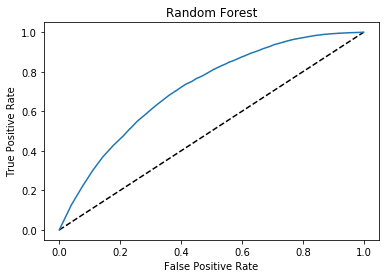

In [82]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rfc_mp_4, tpr_rfc_mp_4, label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest')
plt.show();

In [83]:
auc_score_rfc_mp_4 = roc_auc_score(y_test, y_pred_prob_rfc_mp_4)
auc_score_rfc_mp_4

0.7174948862609082

In [23]:
y_pred_prob_upsampled_mp_1 = upsampled_mp_1.predict_proba(X_test)[:,1]
y_pred_prob_upsampled_mp_1

array([0.36550222, 0.50245268, 0.56292927, ..., 0.66480685, 0.89902847,
       0.71783947])

In [24]:
fpr_upsampled_mp_1, tpr_upsampled_mp_1, thresholds_upsampled_mp_1 = roc_curve(y_test, y_pred_prob_upsampled_mp_1)

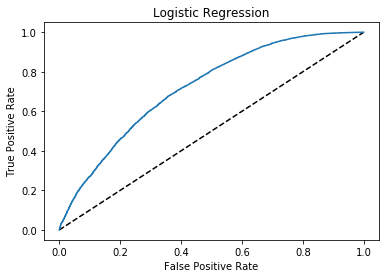

In [25]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_upsampled_mp_1, tpr_upsampled_mp_1, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression')
plt.show();

In [26]:
auc_score_upsampled_mp_1 = roc_auc_score(y_test, y_pred_prob_upsampled_mp_1)
auc_score_upsampled_mp_1

0.7188377466770857

The 'upsampled_mp_1' LogisticRegression algorithm has a slightly higher AUC score than the RandomForest algorithm with 100 estimators.

## Precision Recall Curve

Because of the imbalanced class count, the 1st LogisticRegression algorithm is evaluated below with a Precision-Recall Curve, as recommended by this article by Jason Brownlee, PhD: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/. As Dr. Brownlee says, the future performance of a model with imbalanced class counts is better evaluated with a Precision-Recall Curve than an ROC curve. Specific modules are first imported for use in calculating the Precision-Recall Curve.

In [27]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

The precision recall curve is defined below, as is the F1 score and AUC for the precision-recall curve.

In [28]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred_prob_upsampled_mp_1)

In [29]:
lr_mp_f1, lr_mp_auc = f1_score(y_test, upsampled_mp_pred_1), auc(lr_recall, lr_precision)

The scores are then summarized.

In [30]:
print('Logistic: f1=%.3f auc=%.3f' % (lr_mp_f1, lr_mp_auc))

Logistic: f1=0.822 auc=0.948


The precision-recall curve is then plotted for the best Logistic Regression algorithm. The precision-recall curve's AUC is very high, showing that the algorithm is skilled at differentiating true positives from false positives and false negatives.

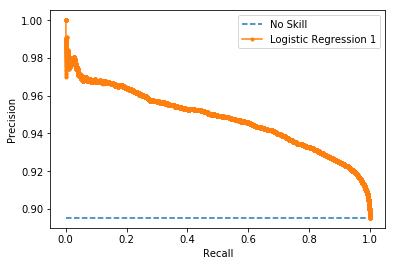

In [31]:
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic Regression 1')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## Evaluation of the Classification Models for Misdemeanor Possession

The best LogisticRegression model ('upsampled_mp_1') has an accuracy of 0.71596196182565, showing that it makes correct predictions on roughly 71.6% of the data points in the DataFrame.

The model's precision is 0.94 for the misdemeanor possession class (the 1 class), 0.20 for the other cannabis crime types class (the 0 class), and 0.86 on weighted average, showing that 94% of predicted misdemeanor  possession crimes are actual misdemeanor possession crimes, 20% of predicted other cannabis crimes are actual other cannabis crimes, and 86% of cannabis crimes on average are predicted correctly. 

The model's recall is 0.73 for the misdemeanor possession class (the 1 class), 0.58 for the other cannabis crime types class (0), and 0.72 on weighted average, showing that 73% of actual misdemeanor possession crimes are predicted as misdemeanor possession crimes, 58% of actual other cannabis crimes are predicted as other cannabis crimes, and that 72% of cannabis crimes on average are predicted correctly.

The model's F1 score, or harmonic mean of precision and recall, is 0.82 for the misdemeanor possession class, 0.30 for the other cannabis crimes class, and 0.77 on weighted average. This metric is more informative than precision or recall alone, and shows that 82% of misdemeanor possession crimes and 30% of other cannabis crimes are being predicted correctly, for a weighted average of 77%.

The ROC curves plotted above show that the best LogisticRegression model ('upsampled_mp_1') has an ROC AUC score of 71.9%, showing that it is a moderately skillful model in predicting misdemeanor possession crimes at a rate higher than random. The Precision Recall Curve has an AUC score of 94.8%. The higher Precision Recall AUC score shows that the model is skilled at differentiating true positives from false positives and false negatives, especially for the cannabis misdemeanor possession class. However, as is shown above, it is not as skillful at predicting the other cannabis crime types as a group. Therefore, this model's coefficients can show the features in the NYPD's dataset that have the strongest statistical relationship with cannabis misdemeanor possession crimes between 2006 and 2018, but the coefficients for the other cannabis crimes types as a whole should be considered as speculative to a certain degree, which is acceptable as the other crime types will be classified individually below.

The RandomForest model with 100 estimators has an accuracy of 0.88034769977985. It has a 0.92 precision score for the misdemeanor possession class, a 0.39 precision score for the other crime types class, and a weighted average precision score of 0.86. The model has a recall score of 0.95 for the misdemeanor possession class, a 0.26 recall score for the other crime types class, and a weighted average recall score of 0.88. It has a 0.93 F1 score for the misdemeanor possession class, a 0.31 F1 score for the other crime types class, and a weighted average F1 score of 0.87. The ROC curve plotted above shows that it has an AUC score of 71.8%. This is a skillful model at predicting misdemeanor possession crimes, but because of its non-linear nature cannot uncover the features in the NYPD's dataset that have the strongest relationship with misdemeanor possession crimes. 

## Coefficients

In order to look at the most salient predictors of cannabis misdemeanor possession crimes in New York City between 2006-2018, the feature set's coefficients for the best performing Logistic Regression algorithm ('upsampled_mp_1') are identified to find the most predictive features differentiating cannabis misdemeanor  possession crimes from all other cannabis crimes.

First, the coefficients are called for all the features in the feature set, assigned to 'best_cf_coeffs' (short for 'best classifier's coefficients').

In [22]:
best_cf_mp_coeffs = pd.Series(upsampled_mp_1.coef_[0], index=X_train.columns) 
best_cf_mp_coeffs

Latitude                                                                       -0.020059
Longitude                                                                       0.021585
duration_days                                                                   0.344732
start_year                                                                      0.207526
start_month                                                                     0.018187
start_day                                                                      -0.030877
start_hour                                                                      0.402335
start_minute                                                                    0.140331
start_seconds                                                                   0.000000
rpt_cmplnt_dt_match                                                             0.554604
day_tw                                                                         -0.368899
night_tw             

The features' coefficients are then sorted to show the features most predictive of cannabis misdemeanor possession crimes. The features with positive coefficients are more predictive of misdemeanor possession crimes, while the features with negative coefficients are more predictive of all other cannabis crimes. Because the '0' class, i.e. "all other cannabis crimes", is non-differentiated, there is no real value to the negative coefficients and they will be ignored.

In [26]:
sorted_best_cf_mp_coeffs = best_cf_mp_coeffs.sort_values()
sorted_best_cf_mp_coeffs

PARKS_NM_WASHINGTON SQUARE PARK                                                -2.507856
SUSP_AGE_GROUP_cleaned_unknown                                                 -1.578642
HADEVELOPT_SOUNDVIEW                                                           -1.334668
PREM_TYP_DESC_BUS (NYC TRANSIT)                                                -1.322817
TRANSIT_DISTRICT_12.0                                                          -1.303148
TRANSIT_DISTRICT_1.0                                                           -1.230998
HADEVELOPT_BRONXDALE                                                           -1.157843
HADEVELOPT_WALD                                                                -1.152608
HADEVELOPT_POMONOK                                                             -1.141669
HADEVELOPT_MONROE                                                              -1.089575
HADEVELOPT_CASTLE HILL                                                         -1.088739
HADEVELOPT_BOYNTON AV

To look at which features have the strongest relationship to misdemeanor possession, the features that have at least a 0.693702 coefficient are called and speculated on below by assigning the object 'sorted_best_cf_mp_coeffs'. When exponentiated by assigning the object 'cannabis_mp_coeffs_lls', these features are shown to provide at least a 2% increase in the odds of a crime being a misdemeanor possession crime.

In [27]:
cannabis_mp_coeffs = sorted_best_cf_mp_coeffs[-35:].sort_values(ascending=False)
cannabis_mp_coeffs

PREM_TYP_DESC_MARINA/PIER                    1.908801
PREM_TYP_DESC_PARK/PLAYGROUND                1.310393
ADDR_PCT_CD_75.0                             1.230284
HADEVELOPT_303 VERNON AVENUE                 1.165603
PREM_TYP_DESC_OPEN AREAS (OPEN LOTS)         1.127491
prospect_pk_l1                               1.102695
PREM_TYP_DESC_RESIDENCE - PUBLIC HOUSING     1.078965
HADEVELOPT_MCKINLEY                          1.040812
TRANSIT_DISTRICT_20.0                        1.021575
TRANSIT_DISTRICT_34.0                        0.996220
ADDR_PCT_CD_77.0                             0.994689
will_bridge_l2                               0.948751
TRANSIT_DISTRICT_23.0                        0.907015
PREM_TYP_DESC_PARKING LOT/GARAGE (PUBLIC)    0.896159
STATION_NAME_NOSTRAND AVENUE                 0.881081
HADEVELOPT_OCEAN HILL-BROWNSVILLE            0.842997
ADDR_PCT_CD_73.0                             0.830711
PREM_TYP_DESC_SOCIAL CLUB/POLICY             0.821493
SUSP_SEX_cleaned_unknown    

In [28]:
cannabis_mp_coeffs_lls = np.array(np.exp(cannabis_mp_coeffs))
cannabis_mp_coeffs_lls

array([6.74499577, 3.7076298 , 3.42220199, 3.20785681, 3.08789829,
       3.01227344, 2.94163475, 2.831514  , 2.77756657, 2.7080274 ,
       2.70388396, 2.58248169, 2.47691868, 2.45017499, 2.41350783,
       2.32331936, 2.29495035, 2.2738925 , 2.26599723, 2.26095318,
       2.25167699, 2.24863049, 2.24537908, 2.23244657, 2.23155811,
       2.22804475, 2.21277391, 2.12754131, 2.07338111, 2.05723171,
       2.0422093 , 2.02554045, 2.02315832, 2.02231171, 2.00111026])

## Feature Set Coefficients and Likelihoods for Misdemeanor Possession

The features, their coefficients, and the increased likelihood towards misdemeanor possession crime are called in an Excel table below.

In [30]:
mp_coeffs_lls_table = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='mp_coeffs')
mp_coeffs_lls_table

,Feature,Coefficient,Increased Odds Towards Misdemeanor Possession Class
0,PREM_TYP_DESC_MARINA/PIER,1.908801,6.744996
1,PREM_TYP_DESC_PARK/PLAYGROUND,1.310393,3.707630
2,ADDR_PCT_CD_75.0,1.230284,3.422202
3,HADEVELOPT_303 VERNON AVENUE,1.165603,3.207857
4,PREM_TYP_DESC_OPEN AREAS (OPEN LOTS),1.127491,3.087898
5,prospect_pk_l1,1.102695,3.012273
6,PREM_TYP_DESC_RESIDENCE - PUBLIC HOUSING,1.078965,2.941635
7,HADEVELOPT_MCKINLEY,1.040812,2.831514
8,TRANSIT_DISTRICT_20.0,1.021575,2.777567
9,TRANSIT_DISTRICT_34.0,0.996220,2.708027


The specific premises features with the highest coefficients and likelihoods show that misdemeanor possession arrests have the strongest relationship with marinas and piers, parks and playgrounds, open areas and lots, public housing residences, public parking lots and garages, and social clubs, in descending order. These features have increased likelihoods of cannabis crimes being misdemeanor possession crimes between 6.7% and 2.3%, with marinas and piers having the highest likelihoods and social clubs having the least. Some of these features reflect how cannabis users must utilize open public spaces to smoke and be caught by the police. Notably, the high rates of cannabis arrests in public housing buildings is again shown with the "PREM_TYP_DESC_RESIDENCE - PUBLIC HOUSING" feature's coefficient of 0.9 and increased likelihood of a misdemeanor possession charge of 2.9%. Also, the definition of the feature "PREM_TYP_DESC_SOCIAL CLUB/POLICY" is unclear, but it seems misdemeanor possession charges are occurring in social clubs in New York City. Whether these are private clubs being raided or normal public bars and music clubs is unclear.

The only NYC parks with a notable relationship with misdemeanor possession are Claremont Park in the South Bronx (2.3% increased odds of misdemeanor possession) and Riverside Park in the Riverside neighborhood of the Upper West Side of Manhattan (2.2% increased odds).

There are three transit subway stations with a notable relationship with misdemeanor possession:

- Nostrand Avenue in Crown Heights, which has a long-standing Afro-Caribbean population (2.4% increased odds), 

- Queensboro Plaza near Long Island City, Queens (2.2% increased odds), and 

- 168 St. Washington Heights in the traditionally Hispanic neighborhood of Washington Heights (2% increased odds)

There are three transit districts that have a relationship with misdemeanor possession:

- Transit District 20 in Jamaica, NY (2.8% increased odds),

- Transit District 34 in Coney Island, Brooklyn (2.7% increased odds), and 

- Transit District 23 in Rockaway Park, Brooklyn (2.5% increased odds)

Cannabis arrests with missing suspect sex are 2.3% more likely to be misdemeanor possession arrests than all other cannabis arrests. This shows that there is some underlying reason why the suspect's sex is not being recorded for misdemeanor possession arrests.  The causal reason can't be identified with this analysis, but future research is definitely needed in this area. It is shown in a value counts cell below that 84% of misdemeanor possession arrests did not have the suspect's sex recorded.

The L1 distance to Prospect Park also has a notable relationship with misdemeanor possession crime, with an increased odds of 3% that a cannabis crime is a misdemeanor possession crime. This may have to do with public smoking in the park, or its proximity to several heavily African-American neighorhoods like Crown Heights and Flatbush.

The L2 distance to the Williamsburg Bridge also has a notable relationship with misdemeanor possession crime, with an increased odds of 2.6% that a cannabis crime is a misdemeanor possession crime. Williamsburg and the Lower East Side are two neighborhoods on either side of the Williamsburg Bridge, both of which are known as countercultural or "hipster" neighborhoods, which may explain the relationship. There is also a Williamsburg housing development close to the bridge, which is shown below to have a strong relationship with cannabis crime.

The L2 distance to the closest subway station entrance also has a notable relationship with cannabis misdemeanor possession crime, with an increased odds of 2%. This shows that the closer to a subway station a cannabis arrest is in a straight line, the more likely it is a misdemeanor possession arrest and the less likely it is another type of cannabis crime.

Police precincts with the highest relationship to cannabis misdemeanor possession crime, in descending order, are the 75th, 77th, 73rd, 43rd, 100th and 115th. Precinct descriptions come from https://www1.nyc.gov/site/nypd/bureaus/patrol/precincts-landing.page. These cover the following areas:

- 75th - East New York and Cypress Hills neighborhoods of Easternmost Brooklyn (3.4% increase)

- 77th - Northern portion of Crown Heights and part of Prospect Heights neighborhoods in Central Brooklyn (2.7% increase)

- 73rd - Brownsville and Ocean Hill neighborhoods of northeastern Brooklyn (2.3% increase)

- 43rd - Southeast section of the Bronx, with the four primary commercial strips of Westchester Avenue, Castle Hill Avenue, White Plains Road, and Parkchester (2.3% increase)

- 100th - Arverne, Belle Harbor, Breezy Point, Broad Channel, Neponsit, Rockaway Park, Rockaway Beach, and Roxbury neighborhoods of Queens (2.1% increase)

- 115th - Jackson Heights, East Elmhurst, and North Corona neighborhoods of northern Queens, including La Guardia Airport (2% increase)

Certain public housing developments (or projects) have a strong relationship with cannabis misdemeanor possession crimes. They include:

- 303 Vernon Avenue in the Bedford-Stuyvesant neighborhood of Central Brooklyn (3.2% increase),

- McKinley in the Morrisania neighborhood of the South Bronx (2.8% increase),

- Ocean Hill Houses in the Brownsville neighborhood of East Brooklyn (2.3% increase)

- Edenwald in the Edenwald neighborhood of the North Bronx (2.3% increase),

- Morrisania Air Rights 42 in the Morrisania neighborhood of the South Bronx (2.3% increase),

- Borinquen Plaza II in Bushwick, in a classically Puerto Rican neighborhood of Brooklyn (2.3% increase), 

- Adams in the South Bronx (2.2% increase),

- Sheepshead Bay in the Sheepshead Bay neighborhood of South Brooklyn (2.1% increase),

- Williams Plaza in the South Williamsburg neighborhood of Brooklyn (2.1% increase),

- Dyckman in the Inwood neighborhood of North Manhattan (2% increase), and 

- Mill Brook in the Mott Haven neighborhood of the South Bronx (2% increase)

In [52]:
unknown_susp_sex_mp = df_mp[df_mp.misd_poss == 1]['SUSP_SEX_cleaned_unknown'].value_counts()
unknown_susp_sex_mp

1    166276
0     30948
Name: SUSP_SEX_cleaned_unknown, dtype: int64

## Relationship of 'Feature Families' to Crime: Misdemeanor Possession and Other Cannabis Crime Types

Because there are so many binarized features in the feature set, the interpretability of these features' coefficients and increased odds towards misdemeanor possession is better enabled by grouping the features into "feature families" (e.g. suspect race, borough, housing development). This grouping strategy involves taking the absolute value sum of all coefficients in the feature set, then summing the absolute values of the coefficients for each "feature family", and then dividing the absolute value coefficient sum of each "feature family" by the total absolute value coefficient sum to uncover the proportion of the total predictive value that each "feature family" has. This will help elucidate the "feature families" that have the strongest predictive power on whether a crime is a misdemeanor possession crime or another type of cannabis crime, and therefore which feature families should be explored further as having the strongest relationship to misdemeanor possession.

A summary table of the sum of all coefficients, the sum of coefficients for each feature family, and the proportion of the total sum of all coefficients that each feature family has is called below. Any family with more than 9 percent of the total coefficient sum will be examined further. That includes housing developments, NYC parks, transit stations, police precincts, and premises types. Because suspect race is a main concern of arrest biases when it comes to cannabis crime, it is also examined.

In [130]:
proportions_table_mp = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='mp_family_props')
proportions_table_mp

,Feature Family,Sum of Coeffs,Proportion of Total Coeffs,Unnamed: 3
0,"Sum of all coeffs, absolute value",NaN,NaN,291.914241
1,Housing Developments,88.700706,0.303859,NaN
2,NYC Parks,52.485507,0.179798,NaN
3,Transit Stations,44.542817,0.152589,NaN
4,Police Precincts,28.515009,0.097683,NaN
5,Premises Types,28.151908,0.096439,NaN
6,L1 Distances from NYC Landmarks,8.658727,0.029662,NaN
7,Transit Districts,8.480704,0.029052,NaN
8,L2 Distances from NYC Landmarks,7.563271,0.025909,NaN
9,Jurisdictions of Crime,5.959239,0.020414,NaN


In [38]:
sum_of_all_coeffs_mp = np.sum(abs(sorted_best_cf_mp_coeffs.values))
sum_of_all_coeffs_mp

291.91424071294654

In [39]:
is_race_coeffs_mp = []
for name in sorted_best_cf_mp_coeffs.index.values:
    is_race_coeffs_mp.append(name.startswith('SUSP_RACE_'))
is_race_coeffs_mp = np.array(is_race_coeffs_mp)

In [40]:
race_coeffs_mp = sorted_best_cf_mp_coeffs.loc[is_race_coeffs_mp]

In [41]:
sum_of_race_coeffs_mp = np.sum(abs(race_coeffs_mp.values))
sum_of_race_coeffs_mp

1.3729502298968181

In [42]:
race_proportion_of_total_mp = sum_of_race_coeffs_mp / sum_of_all_coeffs_mp
race_proportion_of_total_mp

0.004703265680165658

In [44]:
is_police_precinct_coeffs_mp = []
for name in sorted_best_cf_mp_coeffs.index.values:
    is_police_precinct_coeffs_mp.append(name.startswith('ADDR_PCT_CD_'))
is_police_precinct_coeffs_mp = np.array(is_police_precinct_coeffs_mp)

In [45]:
police_precinct_coeffs_mp = sorted_best_cf_mp_coeffs.loc[is_police_precinct_coeffs_mp]

In [46]:
sum_of_police_precinct_coeffs_mp = np.sum(abs(police_precinct_coeffs_mp.values))
sum_of_police_precinct_coeffs_mp

28.515008991007573

In [47]:
police_precinct_proportion_of_total_mp = sum_of_police_precinct_coeffs_mp / sum_of_all_coeffs_mp
police_precinct_proportion_of_total_mp

0.09768282945485954

In [48]:
is_borough_coeffs_mp = []
for name in sorted_best_cf_mp_coeffs.index.values:
    is_borough_coeffs_mp.append(name.startswith('BORO_NM_'))
is_borough_coeffs_mp = np.array(is_borough_coeffs_mp)

In [49]:
borough_coeffs_mp = sorted_best_cf_mp_coeffs.loc[is_borough_coeffs_mp]

In [50]:
sum_of_borough_coeffs_mp = np.sum(abs(borough_coeffs_mp.values))
sum_of_borough_coeffs_mp

0.7847626103908242

In [51]:
borough_proportion_of_total_mp = sum_of_borough_coeffs_mp / sum_of_all_coeffs_mp
borough_proportion_of_total_mp

0.002688332739349018

In [52]:
is_housing_developt_coeffs_mp = []
for name in sorted_best_cf_mp_coeffs.index.values:
    is_housing_developt_coeffs_mp.append(name.startswith('HADEVELOPT_'))
is_housing_developt_coeffs_mp = np.array(is_housing_developt_coeffs_mp)

In [53]:
housing_developt_coeffs_mp = sorted_best_cf_mp_coeffs.loc[is_housing_developt_coeffs_mp]

In [54]:
sum_of_housing_developt_coeffs_mp = np.sum(abs(housing_developt_coeffs_mp.values))
sum_of_housing_developt_coeffs_mp

88.70070649092152

In [55]:
housing_developt_proportion_of_total_mp = sum_of_housing_developt_coeffs_mp / sum_of_all_coeffs_mp
housing_developt_proportion_of_total_mp

0.3038587849441208

In [56]:
is_juris_desc_coeffs_mp = []
for name in sorted_best_cf_mp_coeffs.index.values:
    is_juris_desc_coeffs_mp.append(name.startswith('JURIS_DESC_'))
is_juris_desc_coeffs_mp = np.array(is_juris_desc_coeffs_mp)

In [57]:
juris_desc_coeffs_mp = sorted_best_cf_mp_coeffs.loc[is_juris_desc_coeffs_mp]

In [58]:
sum_of_juris_desc_coeffs_mp = np.sum(abs(juris_desc_coeffs_mp.values))
sum_of_juris_desc_coeffs_mp

5.959238941941439

In [59]:
juris_desc_proportion_of_total_mp = sum_of_juris_desc_coeffs_mp / sum_of_all_coeffs_mp
juris_desc_proportion_of_total_mp

0.020414348157140605

In [60]:
is_loc_of_occur_desc_coeffs_mp = []
for name in sorted_best_cf_mp_coeffs.index.values:
    is_loc_of_occur_desc_coeffs_mp.append(name.startswith('LOC_OF_OCCUR_DESC_'))
is_loc_of_occur_desc_coeffs_mp = np.array(is_loc_of_occur_desc_coeffs_mp)

In [61]:
loc_of_occur_desc_coeffs_mp = sorted_best_cf_mp_coeffs.loc[is_loc_of_occur_desc_coeffs_mp]

In [62]:
sum_of_loc_of_occur_desc_coeffs_mp = np.sum(abs(loc_of_occur_desc_coeffs_mp.values))
sum_of_loc_of_occur_desc_coeffs_mp

0.6863040555557351

In [63]:
loc_of_occur_desc_proportion_of_total_mp = sum_of_loc_of_occur_desc_coeffs_mp / sum_of_all_coeffs_mp
loc_of_occur_desc_proportion_of_total_mp

0.002351046848141305

In [65]:
latitude_coeff_proportion_of_total_mp = abs(sorted_best_cf_mp_coeffs.loc['Latitude']) / sum_of_all_coeffs_mp
latitude_coeff_proportion_of_total_mp

6.871546486421297e-05

In [66]:
longitude_coeff_proportion_of_total_mp = abs(sorted_best_cf_mp_coeffs.loc['Longitude']) / sum_of_all_coeffs_mp
longitude_coeff_proportion_of_total_mp

7.394177140111874e-05

In [67]:
is_parks_coeffs_mp = []
for name in sorted_best_cf_mp_coeffs.index.values:
    is_parks_coeffs_mp.append(name.startswith('PARKS_NM_'))
is_parks_coeffs_mp = np.array(is_parks_coeffs_mp)

In [68]:
parks_coeffs_mp = sorted_best_cf_mp_coeffs.loc[is_parks_coeffs_mp]

In [69]:
sum_of_parks_coeffs_mp = np.sum(abs(parks_coeffs_mp.values))
sum_of_parks_coeffs_mp

52.485506953159906

In [70]:
parks_proportion_of_total_mp = sum_of_parks_coeffs_mp / sum_of_all_coeffs_mp
parks_proportion_of_total_mp

0.17979769272295096

In [71]:
is_patrol_boro_coeffs_mp = []
for name in sorted_best_cf_mp_coeffs.index.values:
    is_patrol_boro_coeffs_mp.append(name.startswith('PATROL_BORO_'))
is_patrol_boro_coeffs_mp = np.array(is_patrol_boro_coeffs_mp)

In [72]:
patrol_boro_coeffs_mp = sorted_best_cf_mp_coeffs.loc[is_patrol_boro_coeffs_mp]

In [73]:
sum_of_patrol_boro_coeffs_mp = np.sum(abs(patrol_boro_coeffs_mp.values))
sum_of_patrol_boro_coeffs_mp

2.194947579866059

In [74]:
patrol_boro_proportion_of_total_mp = sum_of_patrol_boro_coeffs_mp / sum_of_all_coeffs_mp
patrol_boro_proportion_of_total_mp

0.007519152112981216

In [75]:
is_prem_typ_desc_coeffs_mp = []
for name in sorted_best_cf_mp_coeffs.index.values:
    is_prem_typ_desc_coeffs_mp.append(name.startswith('PREM_TYP_DESC_'))
is_prem_typ_desc_coeffs_mp = np.array(is_prem_typ_desc_coeffs_mp)

In [76]:
prem_typ_desc_coeffs_mp = sorted_best_cf_mp_coeffs.loc[is_prem_typ_desc_coeffs_mp]

In [77]:
sum_of_prem_typ_desc_coeffs_mp = np.sum(abs(prem_typ_desc_coeffs_mp.values))
sum_of_prem_typ_desc_coeffs_mp

28.151908234691746

In [78]:
prem_typ_desc_proportion_of_total_mp = sum_of_prem_typ_desc_coeffs_mp / sum_of_all_coeffs_mp
prem_typ_desc_proportion_of_total_mp

0.09643896839680009

In [79]:
is_station_name_coeffs_mp = []
for name in sorted_best_cf_mp_coeffs.index.values:
    is_station_name_coeffs_mp.append(name.startswith('STATION_NAME_'))
is_station_name_coeffs_mp = np.array(is_station_name_coeffs_mp)

In [80]:
station_name_coeffs_mp = sorted_best_cf_mp_coeffs.loc[is_station_name_coeffs_mp]

In [81]:
sum_of_station_name_coeffs_mp = np.sum(abs(station_name_coeffs_mp.values))
sum_of_station_name_coeffs_mp

44.54281705788641

In [82]:
station_name_proportion_of_total_mp = sum_of_station_name_coeffs_mp / sum_of_all_coeffs_mp
station_name_proportion_of_total_mp

0.15258870875603334

In [83]:
is_susp_age_coeffs_mp = []
for name in sorted_best_cf_mp_coeffs.index.values:
    is_susp_age_coeffs_mp.append(name.startswith('SUSP_AGE_'))
is_susp_age_coeffs_mp = np.array(is_susp_age_coeffs_mp)

In [84]:
susp_age_coeffs_mp = sorted_best_cf_mp_coeffs.loc[is_susp_age_coeffs_mp]

In [86]:
sum_of_susp_age_coeffs_mp = np.sum(abs(susp_age_coeffs_mp.values))
sum_of_susp_age_coeffs_mp

3.119442269021641

In [87]:
susp_age_proportion_of_total_mp = sum_of_susp_age_coeffs_mp / sum_of_all_coeffs_mp
susp_age_proportion_of_total_mp

0.010686159953700718

In [88]:
is_susp_sex_coeffs_mp = []
for name in sorted_best_cf_mp_coeffs.index.values:
    is_susp_sex_coeffs_mp.append(name.startswith('SUSP_SEX_'))
is_susp_sex_coeffs_mp = np.array(is_susp_sex_coeffs_mp)

In [89]:
susp_sex_coeffs_mp = sorted_best_cf_mp_coeffs.loc[is_susp_sex_coeffs_mp]

In [90]:
sum_of_susp_sex_coeffs_mp = np.sum(abs(susp_sex_coeffs_mp.values))
sum_of_susp_sex_coeffs_mp

1.6738715137109097

In [91]:
susp_sex_proportion_of_total_mp = sum_of_susp_sex_coeffs_mp / sum_of_all_coeffs_mp
susp_sex_proportion_of_total_mp

0.005734120780208558

In [92]:
is_transit_district_coeffs_mp = []
for name in sorted_best_cf_mp_coeffs.index.values:
    is_transit_district_coeffs_mp.append(name.startswith('TRANSIT_DISTRICT_'))
is_transit_district_coeffs_mp = np.array(is_transit_district_coeffs_mp)

In [94]:
transit_district_coeffs_mp = sorted_best_cf_mp_coeffs.loc[is_transit_district_coeffs_mp]

In [95]:
sum_of_transit_district_coeffs_mp = np.sum(abs(transit_district_coeffs_mp.values))
sum_of_transit_district_coeffs_mp

8.4807040456276

In [96]:
transit_district_proportion_of_total_mp = sum_of_transit_district_coeffs_mp / sum_of_all_coeffs_mp
transit_district_proportion_of_total_mp

0.0290520394788382

In [103]:
holidays_mp = ['christmas', 'christmas_eve', 'diwali', 'easter', 'eid_al_adha', 'eid_al_fitr', 'four_twenty', 
           'halloween', 'hanukkah', 'july_4th', 'labor_day', 'memorial_day', 'mlk', 'new_years_day', 
           'new_years_eve', 'pr_parade', 'pres', 'rosh_hashanah', 'st_patricks', 'thanksgiving', 
           'valentines', 'yomkippur']

In [104]:
is_holidays_coeffs_mp = []
for name in sorted_best_cf_mp_coeffs.index.values:
    is_holidays_coeffs_mp.append(name in holidays_mp)
is_holidays_coeffs_mp = np.array(is_holidays_coeffs_mp)

In [105]:
holidays_coeffs_mp = sorted_best_cf_mp_coeffs.loc[is_holidays_coeffs_mp]

In [106]:
sum_of_holidays_coeffs_mp = np.sum(abs(holidays_coeffs_mp.values))
sum_of_holidays_coeffs_mp

3.7983778827801573

In [107]:
holidays_proportion_of_total_mp = sum_of_holidays_coeffs_mp / sum_of_all_coeffs_mp
holidays_proportion_of_total_mp

0.013011964998704146

In [108]:
time_windows_mp = ['day_tw', 'dinner', 'early_morn', 'eve_rush_hr', 'evening', 'late_night', 'lunch_hr', 
                'morn_rush_hr', 'night_tw', 'work_day']

In [110]:
is_time_windows_coeffs_mp = []
for name in sorted_best_cf_mp_coeffs.index.values:
    is_time_windows_coeffs_mp.append(name in time_windows_mp)
is_time_windows_coeffs_mp = np.array(is_time_windows_coeffs_mp)

In [111]:
time_windows_coeffs_mp = sorted_best_cf_mp_coeffs.loc[is_time_windows_coeffs_mp]

In [112]:
sum_of_time_windows_coeffs_mp = np.sum(abs(time_windows_coeffs_mp.values))
sum_of_time_windows_coeffs_mp

2.1667288273266054

In [113]:
time_windows_proportion_of_total_mp = sum_of_time_windows_coeffs_mp / sum_of_all_coeffs_mp
time_windows_proportion_of_total_mp

0.007422484158480145

In [114]:
l1_landmark_dists_mp = ['apollo_th_l1', 'bk_bridge_l1', 'central_pk_l1', 'city_hall_l1', 'downtown_bk_l1', 
                    'empire_st_bldg_l1', 'lincoln_ctr_l1', 'manh_bridge_l1', 'mdc_l1', 'mets_stad_l1', 
                    'nypd_hq_l1', 'nysc_l1', 'nyse_l1', 'penn_station_l1', 'port_authority_l1', 
                    'prospect_pk_l1', 'queens_l1', 'rikers_l1', 'rock_center_l1', 'si_ferry_l1', 
                    'times_sq_l1', 'union_sq_l1', 'wash_sq_park_l1', 'will_bridge_l1', 'wtc_l1', 'yankee_stad_l1']

In [115]:
is_l1_landmark_dists_coeffs_mp = []
for name in sorted_best_cf_mp_coeffs.index.values:
    is_l1_landmark_dists_coeffs_mp.append(name in l1_landmark_dists_mp)
is_l1_landmark_dists_coeffs_mp = np.array(is_l1_landmark_dists_coeffs_mp)

In [116]:
l1_landmark_dists_coeffs_mp = sorted_best_cf_mp_coeffs.loc[is_l1_landmark_dists_coeffs_mp]

In [117]:
sum_of_l1_landmark_dists_coeffs_mp = np.sum(abs(l1_landmark_dists_coeffs_mp.values))
sum_of_l1_landmark_dists_coeffs_mp

8.658727370685861

In [118]:
l1_landmark_dists_proportion_of_total_mp = sum_of_l1_landmark_dists_coeffs_mp / sum_of_all_coeffs_mp
l1_landmark_dists_proportion_of_total_mp

0.029661887510313033

In [119]:
l2_landmark_dists_mp = ['apollo_th_l2', 'bk_bridge_l2', 'central_pk_l2', 'city_hall_l2', 'downtown_bk_l2', 
                    'empire_st_bldg_l2', 'lincoln_ctr_l2', 'manh_bridge_l2', 'mdc_l2', 'mets_stad_l2', 
                    'nypd_hq_l2', 'nysc_l2', 'nyse_l2', 'penn_station_l2', 'port_authority_l2', 
                    'prospect_pk_l2', 'queens_l2', 'rikers_l2', 'rock_center_l2', 'si_ferry_l2', 
                    'times_sq_l2', 'union_sq_l2', 'wash_sq_park_l2', 'will_bridge_l2', 'wtc_l2', 'yankee_stad_l2']

In [120]:
is_l2_landmark_dists_coeffs_mp = []
for name in sorted_best_cf_mp_coeffs.index.values:
    is_l2_landmark_dists_coeffs_mp.append(name in l2_landmark_dists_mp)
is_l2_landmark_dists_coeffs_mp = np.array(is_l2_landmark_dists_coeffs_mp)

In [121]:
l2_landmark_dists_coeffs_mp = sorted_best_cf_mp_coeffs.loc[is_l2_landmark_dists_coeffs_mp]

In [122]:
sum_of_l2_landmark_dists_coeffs_mp = np.sum(abs(l2_landmark_dists_coeffs_mp.values))
sum_of_l2_landmark_dists_coeffs_mp

7.563271398321376

In [123]:
l2_landmark_dists_proportion_of_total_mp = sum_of_l2_landmark_dists_coeffs_mp / sum_of_all_coeffs_mp
l2_landmark_dists_proportion_of_total_mp

0.02590922381809632

In [124]:
sw_dist_l1_coeff_proportion_of_total_mp = abs(sorted_best_cf_mp_coeffs.loc['closest_subway_distance_l1']) / sum_of_all_coeffs_mp
sw_dist_l1_coeff_proportion_of_total_mp

0.002071492099184634

In [125]:
sw_dist_l2_coeff_proportion_of_total_mp = abs(sorted_best_cf_mp_coeffs.loc['closest_subway_distance_l2']) / sum_of_all_coeffs_mp
sw_dist_l2_coeff_proportion_of_total_mp

0.0024460341795308847

In [126]:
duration_coeff_proportion_of_total_mp = abs(sorted_best_cf_mp_coeffs.loc['duration_days']) / sum_of_all_coeffs_mp
duration_coeff_proportion_of_total_mp

0.0011809357624415545

In [127]:
rpt_cmplnt_dt_match_coeff_proportion_of_total_mp = abs(sorted_best_cf_mp_coeffs.loc['rpt_cmplnt_dt_match']) / sum_of_all_coeffs_mp
rpt_cmplnt_dt_match_coeff_proportion_of_total_mp

0.0018998867969717995

## Relationship of Housing Developments to Misdemeanor Possession

Out of all the feature families, the occurrence of a crime in a housing development most predicts which type of cannabis crime it is, misdemeanor possession or not misdemeanor possession. The absolute sum of its coefficients is 88.7, and its percentage of the entire absolute sum of coefficients is 30.4%. This definitely warrants looking closer at the strength of the relationship that housing developments have with misdemeanor possession cannabis crime.

Shown below are the specific housing developments where the coefficients, when exponentiated, show at least a 2% increased likelihood that a specific crime is a misdemeanor possession cannabis crime. Therefore, these specific housing developments show a moderate to strong relationship with misdemeanor possession cannabis crime.

In [140]:
top_hds_mp = housing_developt_coeffs_mp[-11:].sort_values(ascending=False)
top_hds_mp

HADEVELOPT_303 VERNON AVENUE           1.165603
HADEVELOPT_MCKINLEY                    1.040812
HADEVELOPT_OCEAN HILL-BROWNSVILLE      0.842997
HADEVELOPT_EDENWALD                    0.811675
HADEVELOPT_MORRISANIA AIR RIGHTS 42    0.808874
HADEVELOPT_BORINQUEN PLAZA II          0.802700
HADEVELOPT_ADAMS                       0.794247
HADEVELOPT_SHEEPSHEAD BAY              0.754967
HADEVELOPT_WILLIAMS PLAZA              0.729181
HADEVELOPT_DYCKMAN                     0.705837
HADEVELOPT_MILL BROOK                  0.693702
dtype: float64

In [141]:
top_hds_mp_lls = np.array(np.exp(top_hds_mp))
top_hds_mp_lls

array([3.20785681, 2.831514  , 2.32331936, 2.25167699, 2.24537908,
       2.23155811, 2.21277391, 2.12754131, 2.07338111, 2.02554045,
       2.00111026])

Certain public housing developments (or projects) have a strong relationship with cannabis misdemeanor possession crimes. They include:

- 303 Vernon Avenue in the Bedford-Stuyvesant neighborhood of Central Brooklyn (3.2% increase),

- McKinley in the Morrisania neighborhood of the South Bronx (2.8% increase),

- Ocean Hill Houses in the Brownsville neighborhood of East Brooklyn (2.3% increase)

- Edenwald in the Edenwald neighborhood of the North Bronx (2.3% increase),

- Morrisania Air Rights 42 in the Morrisania neighborhood of the South Bronx (2.3% increase),

- Borinquen Plaza II in Bushwick, in a classically Puerto Rican neighborhood of Brooklyn (2.3% increase), 

- Adams in the South Bronx (2.2% increase),

- Sheepshead Bay in the Sheepshead Bay neighborhood of South Brooklyn (2.1% increase),

- Williams Plaza in the South Williamsburg neighborhood of Brooklyn (2.1% increase),

- Dyckman in the Inwood neighborhood of North Manhattan (2% increase), and 

- Mill Brook in the Mott Haven neighborhood of the South Bronx (2% increase)

As can be seen below, the bidirectional mean coefficient (not absolute values) for all housing developments is roughly -0.0001, which shows that housing developments on average are not a predictor of whether a crime is classified as a misdemeanor possession or another cannabis crime, and that all types of cannabis crime occur in housing developments. Housing developments are associated with roughly a 1% odds increase in a crime being classified as a misdemeanor possession crime.

In [135]:
mean_hd_coeffs_mp = np.mean(housing_developt_coeffs_mp)
mean_hd_coeffs_mp

-0.00014667299247954227

In [136]:
mean_hd_coeffs_lls_mp = np.exp(mean_hd_coeffs_mp)
mean_hd_coeffs_lls_mp

0.999853337763478

In [160]:
top_hds_lls_table_mp = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='mp_hds_coeffs')
top_hds_lls_table_mp

,Housing Development,Coefficients,Increase in odds
0,HADEVELOPT_303 VERNON AVENUE,1.165603,3.207857
1,HADEVELOPT_MCKINLEY,1.040812,2.831514
2,HADEVELOPT_OCEAN HILL-BROWNSVILLE,0.842997,2.323319
3,HADEVELOPT_EDENWALD,0.811675,2.251677
4,HADEVELOPT_MORRISANIA AIR RIGHTS 42,0.808874,2.245379
5,HADEVELOPT_BORINQUEN PLAZA II,0.802700,2.231558
6,HADEVELOPT_ADAMS,0.794247,2.212774
7,HADEVELOPT_SHEEPSHEAD BAY,0.754967,2.127541
8,HADEVELOPT_WILLIAMS PLAZA,0.729181,2.073381
9,HADEVELOPT_DYCKMAN,0.705837,2.025540


## Relationship of NYC Parks to Misdemeanor Possession

The occurrence of a crime in an NYC park also predicts which type of cannabis crime it is, misdemeanor possession or not misdemeanor possession. The absolute sum of the NYC park feature's coefficients is 52.5, and its percentage of the entire absolute sum of coefficients is 17.9%. These numbers warrant looking closer at the strength of the relationship that NYC parks have with misdemeanor possession.

Shown below are the specific NYC parks where the coefficients, when exponentiated, show at least a 2% increased likelihood that a specific crime is a misdemeanor possession cannabis crime. Therefore, these specific NYC parks show a moderate to strong relationship with misdemeanor possession.

In [145]:
top_parks_mp = parks_coeffs_mp[-2:].sort_values(ascending=False)
top_parks_mp

PARKS_NM_CLAREMONT PARK    0.810321
PARKS_NM_RIVERSIDE PARK    0.803098
dtype: float64

In [146]:
top_parks_mp_lls = np.array(np.exp(top_parks_mp))
top_parks_mp_lls

array([2.24863049, 2.23244657])

The only NYC parks with a notable relationship with misdemeanor possession are Claremont Park in the South Bronx (2.3% increased odds of misdemeanor possession) and Riverside Park in the Riverside neighborhood of the Upper West Side of Manhattan (2.2% increased odds).

As can be seen below, the bidirectional mean coefficient (not absolute values) for all housing developments is roughly -0.00009, which shows that parks on average are not a predictor of whether a crime is classified as a misdemeanor possession or another cannabis crime, and that all types of cannabis crime occur in parks. Parks are associated with roughly a 1% odds increase in a crime being classified as a misdemeanor possession crime.

In [147]:
mean_parks_coeffs_mp = np.mean(parks_coeffs_mp)
mean_parks_coeffs_mp

-9.053022024422279e-05

In [148]:
mean_parks_coeffs_lls_mp = np.exp(mean_parks_coeffs_mp)
mean_parks_coeffs_lls_mp

0.9999094738774925

In [161]:
top_parks_lls_table_mp = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='mp_parks_coeffs')
top_parks_lls_table_mp

,NYC Parks,Coefficients,Increase in odds
0,PARKS_NM_CLAREMONT PARK,0.810321,2.248630
1,PARKS_NM_RIVERSIDE PARK,0.803098,2.232447
2,"mean, actual values, directional",-0.000091,0.999909


## Relationship of Transit Stations to Misdemeanor Possession

The transit station with which a crime occurs in also has a relationship to which type of cannabis crime it is, misdemeanor possession or another cannabis crime. The absolute sum of transit stations' coefficients is 44.5, and its percentage of the entire absolute sum of coefficients is 15%. This warrants looking closer at the strength of the relationship that transit stations have with misdemeanor possession. 

Shown below are the specific transit stations where the coefficients, when exponentiated, show at least a 2% increased likelihood that a specific crime is a misdemeanor possession crime. Therefore, these specific transit stations show a moderate to strong relationship with misdemeanor possession.

In [151]:
top_stations_mp = station_name_coeffs_mp[-3:].sort_values(ascending=False)
top_stations_mp

STATION_NAME_NOSTRAND AVENUE            0.881081
STATION_NAME_QUEENSBORO PLAZA           0.801124
STATION_NAME_168 ST.-WASHINGTON HTS.    0.704660
dtype: float64

In [152]:
top_stations_mp_lls = np.array(np.exp(top_stations_mp))
top_stations_mp_lls

array([2.41350783, 2.22804475, 2.02315832])

There are three transit subway stations with a notable relationship with misdemeanor possession:

- Nostrand Avenue in Crown Heights, which has a long-standing Afro-Caribbean population (2.4% increased odds), 

- Queensboro Plaza near Long Island City, Queens (2.2% increased odds), and 

- 168 St. Washington Heights in the traditionally Hispanic neighborhood of Washington Heights (2% increased odds)

As can be seen below, the bidirectional mean coefficient (not absolute values) for all subway stations is roughly -0.0001, which shows that subway stations on average are not a predictor of whether a crime is classified as a misdemeanor possession or another cannabis crime, and that all types of cannabis crime occur in subway stations. Subway stations are associated with roughly a 1% odds increase in a crime being classified as a misdemeanor possession crime.

In [153]:
mean_stations_coeffs_mp = np.mean(station_name_coeffs_mp)
mean_stations_coeffs_mp

-0.00012246482871233692

In [154]:
mean_stations_coeffs_lls_mp = np.exp(mean_stations_coeffs_mp)
mean_stations_coeffs_lls_mp

0.9998775426697987

In [162]:
top_stations_lls_table_mp = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='mp_stations_coeffs')
top_stations_lls_table_mp

,Transit Stations,Coefficients,Increase in odds
0,STATION_NAME_NOSTRAND AVENUE,0.881081,2.413508
1,STATION_NAME_QUEENSBORO PLAZA,0.801124,2.228045
2,STATION_NAME_168 ST.-WASHINGTON HTS.,0.704660,2.023158
3,"mean, actual values, directional",-0.000122,0.999878


## Relationship of Police Precincts to Misdemeanor Possession

The police precinct that a crime occurs in also helps predict which type of crime it is, misdemeanor possession or another type of cannabis crime. The absolute sum of the police precincts' coefficients is 28.5, and its percentage of the entire absolute sum of coefficients is 9.8%. This warrants looking closer at the strength of the relationship that police precincts have with misdemeanor possession.

Shown below are the specific police precincts where the coefficients, when exponentiated, show at least a 2% increased likelihood that a specific crime is a misdemeanor cannabis possession crime. Therefore, these specific police precincts show a moderate to strong relationship with misdemeanor possession.

In [156]:
top_precincts_mp = police_precinct_coeffs_mp[-6:].sort_values(ascending=False)
top_precincts_mp

ADDR_PCT_CD_75.0     1.230284
ADDR_PCT_CD_77.0     0.994689
ADDR_PCT_CD_73.0     0.830711
ADDR_PCT_CD_43.0     0.815786
ADDR_PCT_CD_100.0    0.721361
ADDR_PCT_CD_115.0    0.704241
dtype: float64

In [157]:
top_precincts_mp_lls = np.array(np.exp(top_precincts_mp))
top_precincts_mp_lls

array([3.42220199, 2.70388396, 2.29495035, 2.26095318, 2.05723171,
       2.02231171])

Police precincts with the highest relationship to cannabis misdemeanor possession crime, in descending order, are the 75th, 77th, 73rd, 43rd, 100th and 115th.  These cover the following areas:

- 75th - East New York and Cypress Hills neighborhoods of Easternmost Brooklyn (3.4% increase)

- 77th - Northern portion of Crown Heights and part of Prospect Heights neighborhoods in Central Brooklyn (2.7% increase)

- 73rd - Brownsville and Ocean Hill neighborhoods of northeastern Brooklyn (2.3% increase)

- 43rd - Southeast section of the Bronx, with the four primary commercial strips of Westchester Avenue, Castle Hill Avenue, White Plains Road, and Parkchester (2.3% increase)

- 100th - Arverne, Belle Harbor, Breezy Point, Broad Channel, Neponsit, Rockaway Park, Rockaway Beach, and Roxbury neighborhoods of Queens (2.1% increase)

- 115th - Jackson Heights, East Elmhurst, and North Corona neighborhoods of northern Queens, including La Guardia Airport (2% increase)

As can be seen below, the bidirectional mean coefficient (not absolute values) for all police precincts is roughly -0.0005, which shows that police precincts on average are not a predictor of whether a crime is classified as a misdemeanor possession or another cannabis crime. Police precincts are associated with roughly a 1% odds increase in a crime being classified as a misdemeanor possession crime.

In [158]:
mean_precincts_coeffs_mp = np.mean(police_precinct_coeffs_mp)
mean_precincts_coeffs_mp

-0.0004914497670353835

In [159]:
mean_precincts_coeffs_lls_mp = np.exp(mean_precincts_coeffs_mp)
mean_precincts_coeffs_lls_mp

0.999508670974621

In [163]:
top_precincts_lls_table_mp = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='mp_precincts_coeffs')
top_precincts_lls_table_mp

,Police Precincts,Coefficients,Increase in odds
0,ADDR_PCT_CD_75.0,1.230284,3.422202
1,ADDR_PCT_CD_77.0,0.994689,2.703884
2,ADDR_PCT_CD_73.0,0.830711,2.294950
3,ADDR_PCT_CD_43.0,0.815786,2.260953
4,ADDR_PCT_CD_100.0,0.721361,2.057232
5,ADDR_PCT_CD_115.0,0.704241,2.022312
6,"mean, actual values, directional",-0.000491,0.999509


## Relationship of Premises Types to Misdemeanor Possession

The premises type of a crime also helps predict which type of cannabis crime it is, misdemeanor possession or another type. The absolute sum of the premises type coefficients is 28.2, and its percentage of the entire absolute sum of coefficients is 9.6%. This warrants looking closer at the strength of the relationship that premises type has with misdemeanor possession.

Shown below are the specific premises type where the coefficients, when exponentiated, show at least a 2% increased likelihood that a specific crime is a misdemeanor possession cannabis crime. Therefore, these specific premises types show a moderate to strong relationship with misdemeanor possession.

In [165]:
top_premises_mp = prem_typ_desc_coeffs_mp[-6:].sort_values(ascending=False)
top_premises_mp

PREM_TYP_DESC_MARINA/PIER                    1.908801
PREM_TYP_DESC_PARK/PLAYGROUND                1.310393
PREM_TYP_DESC_OPEN AREAS (OPEN LOTS)         1.127491
PREM_TYP_DESC_RESIDENCE - PUBLIC HOUSING     1.078965
PREM_TYP_DESC_PARKING LOT/GARAGE (PUBLIC)    0.896159
PREM_TYP_DESC_SOCIAL CLUB/POLICY             0.821493
dtype: float64

In [166]:
top_premises_mp_lls = np.array(np.exp(top_premises_mp))
top_premises_mp_lls

array([6.74499577, 3.7076298 , 3.08789829, 2.94163475, 2.45017499,
       2.2738925 ])

The specific premises features with the highest coefficients and likelihoods show that misdemeanor possession arrests have the strongest relationship with marinas and piers, parks and playgrounds, open areas and lots, public housing residences, public parking lots and garages, and social clubs, in descending order. These features have increased likelihoods of cannabis crimes being misdemeanor possession crimes between 6.7% and 2.3%, with marinas and piers having the highest likelihoods and social clubs having the least. Some of these features reflect how cannabis users must utilize open public spaces to smoke and be caught by the police. Notably, the high rates of cannabis arrests in public housing buildings is again shown with the "PREM_TYP_DESC_RESIDENCE - PUBLIC HOUSING" feature's coefficient of 0.9 and increased likelihood of a misdemeanor possession charge of 2.9%. Also, the definition of the feature "PREM_TYP_DESC_SOCIAL CLUB/POLICY" is unclear, but it seems misdemeanor possession charges are occurring in social clubs in New York City. Whether these are private clubs being raided or normal public bars and music clubs is unclear.

As can be seen below, the bidirectional mean coefficient (not absolute values) for all premise types is roughly -0.0006, which shows that premise types on average are not a predictor of whether a crime is classified as a misdemeanor possession or another cannabis crime, and that all types of cannabis crime occur in premise types. Premise types are associated with roughly a 1% odds increase in a crime being classified as a misdemeanor possession crime.

In [167]:
mean_premises_coeffs_mp = np.mean(prem_typ_desc_coeffs_mp)
mean_premises_coeffs_mp

-0.0005484294500853249

In [168]:
mean_premises_coeffs_lls_mp = np.exp(mean_premises_coeffs_mp)
mean_premises_coeffs_lls_mp

0.999451720909857

In [169]:
top_premises_lls_table_mp = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='mp_premises_coeffs')
top_premises_lls_table_mp

,Premises Types,Coefficients,Increase in odds
0,PREM_TYP_DESC_MARINA/PIER,1.908801,6.744996
1,PREM_TYP_DESC_PARK/PLAYGROUND,1.310393,3.707630
2,PREM_TYP_DESC_OPEN AREAS (OPEN LOTS),1.127491,3.087898
3,PREM_TYP_DESC_RESIDENCE - PUBLIC HOUSING,1.078965,2.941635
4,PREM_TYP_DESC_PARKING LOT/GARAGE (PUBLIC),0.896159,2.450175
5,PREM_TYP_DESC_SOCIAL CLUB/POLICY,0.821493,2.273893
6,"mean, actual values, directional",-0.000548,0.999452


## Relationship of Suspect Race to Misdemeanor Possession

Race has been at the center of the conversation around cannabis arrests in New York City, and this project has shown that the majority of cannabis arrests between 2006 and 2018 where the suspect's race was reported were of African-Americans and Hispanics with only 8% of these arrests made of Whites. To explore this relationship deeper, the coefficients for the racial groups are called below in the object 'race_coeffs_mp'. The increased odds of a cannabis crime committed by specific racial/ethnic groups being a misdemeanor possession
crime are also called, and displayed in a table below.

In [171]:
race_coeffs_mp

SUSP_RACE_cleaned_ASIAN / PACIFIC ISLANDER         -0.344101
SUSP_RACE_cleaned_BLACK                            -0.181275
SUSP_RACE_cleaned_BLACK HISPANIC                   -0.137716
SUSP_RACE_cleaned_WHITE HISPANIC                   -0.042305
SUSP_RACE_cleaned_AMERICAN INDIAN/ALASKAN NATIVE    0.028011
SUSP_RACE_cleaned_WHITE                             0.210718
SUSP_RACE_cleaned_unknown                           0.428825
dtype: float64

In [172]:
race_coeffs_mp_lls = np.array(np.exp(race_coeffs_mp))
race_coeffs_mp_lls

array([0.70885739, 0.83420618, 0.87134652, 0.95857758, 1.02840715,
       1.23456431, 1.53545235])

Amongst cannabis crime arrestees, Asians and Pacific Islanders are the least associated with misdemeanor possession arrests, while Blacks, Black Hispanics, and White Hispanics have a weaker negative relation with misdemeanor possession. Whites have a weak positive relationship with misdemeanor possession, and unknown race has a moderately strong relationship with this level of cannabis crime, again showing that there is a confounding variable or variables associated with the lack of recording the suspect's race.

As can be seen below, the mean coefficient of suspect race is roughly -0.005, which shows that suspect race is not a predictor of whether a cannabis crime is classified as a misdemeanor possession crime. Suspect race is associated with roughly a 1% increase in a cannabis crime being classified as a misdemeanor possession crime.

In [173]:
mean_race_coeffs_mp = np.mean(race_coeffs_mp)
mean_race_coeffs_mp #strength of relationship between race and target value, in both directions. dealing with more or less likely

-0.00540594744191103

In [174]:
mean_race_coeffs_lls_mp = np.exp(mean_race_coeffs_mp)
mean_race_coeffs_lls_mp

0.9946086383966993

In [175]:
race_coeffs_lls_table_mp = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='mp_race')
race_coeffs_lls_table_mp

,Race,Coefficients,Increase in odds
0,SUSP_RACE_cleaned_ASIAN / PACIFIC ISLANDER,-0.344101,0.708857
1,SUSP_RACE_cleaned_BLACK,-0.181275,0.834206
2,SUSP_RACE_cleaned_BLACK HISPANIC,-0.137716,0.871347
3,SUSP_RACE_cleaned_WHITE HISPANIC,-0.042305,0.958578
4,SUSP_RACE_cleaned_AMERICAN INDIAN/ALASKAN NATIVE,0.028011,1.028407
5,SUSP_RACE_cleaned_WHITE,0.210718,1.234564
6,SUSP_RACE_cleaned_unknown,0.428825,1.535452
7,"mean, actual values, directional",-0.005406,0.994609
